# Mask the Rrs data using sea ice fraction

In [1]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import scipy


In [2]:
def load_data(filepath):
    ds=xr.open_mfdataset(filepath,mask_and_scale=True)
    return ds

## Load Rrs and sea ice

In [4]:
#AVHRR data first

ROOT = "/data/datasets/Projects/TuringCoccolithophoreBlooms"

#filepath = ROOT+"/data/AVHRR_reflectance/monthly_mean/*.nc"
#varname = "filtered_remote_sensing_reflectance"
filepath = ROOT+"/no_backup/TuringCoccolithophoreBlooms/regridded_data/Rrs_560/*.nc"
varname = "Rrs_560"

ds = load_data(filepath)
print(ds)
rrs = ds[varname]

#ensure no data written as nan
rrs.rio.write_nodata(np.nan, inplace=True)
print(f"nodata: {rrs.rio.nodata}")

ValueError: Cannot handle size zero dimensions

In [6]:
#Comparative meteorlogical data

filepath = ROOT+"/no_backup/TuringCoccolithophoreBlooms/regridded_data/analysed_sst/*.nc"
varname = "sea_ice_fraction"

ds = load_data(filepath)
print(ds)
variable = ds[varname]

#ensure no data written as nan
variable.rio.write_nodata(np.nan, inplace=True)
print(f"nodata: {variable.rio.nodata}")

<xarray.Dataset>
Dimensions:                   (time: 424, longitude: 3600, latitude: 1800)
Coordinates:
  * time                      (time) datetime64[ns] 1981-09-16T12:00:00 ... 2...
  * longitude                 (longitude) float64 -179.9 -179.8 ... 179.8 179.9
  * latitude                  (latitude) float64 -89.95 -89.85 ... 89.85 89.95
Data variables:
    analysed_sst              (time, latitude, longitude) float32 dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    mask                      (time, latitude, longitude) float32 dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    sea_ice_fraction          (time, latitude, longitude) float32 dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    analysed_sst_uncertainty  (time, latitude, longitude) float32 dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (12/61)
    CDI:                             Climate Data Interface version 2.1.0 (ht...
    source:                          ATSR<1,2>-ESACCI-

In [7]:
#Resample so dates are consistent

da = rrs.resample(time='1m').sum(skipna=False)
ds = variable.resample(time='1m').sum(skipna=False)

time = np.array(da.time)

In [36]:
masked = da.where((ds < 0.15), drop=False)

In [37]:
masked

<xarray.DataArray 'filtered_remote_sensing_reflectance' (time: 424,
                                                         latitude: 1800,
                                                         longitude: 3600)>
dask.array<where, shape=(424, 1800, 3600), dtype=float64, chunksize=(1, 1800, 3600), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * latitude   (latitude) float64 -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * time       (time) datetime64[ns] 1981-09-30 1981-10-31 ... 2016-12-31
Attributes:
    units:         sr-1
    long_name:     temporally filtered AVHRR remote sensing reflectance at th...
    cell_methods:  time: mean
    _FillValue:    nan

2000-06


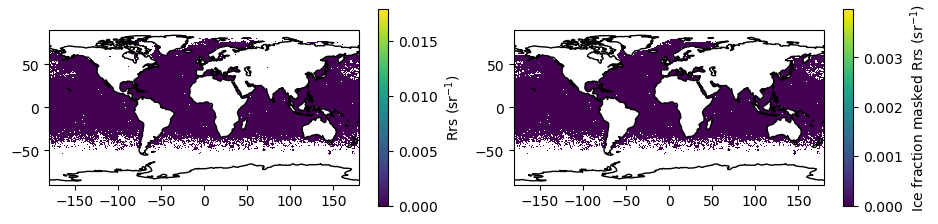

In [47]:
from matplotlib import colors

# Define the figure and each axis
fig, ax = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},figsize=(11,8.5))

index = np.datetime64('2000-06')
print(index)

ax[0].coastlines()
pcm = ax[0].pcolormesh(rrs.longitude,rrs.latitude,da.sel(time=index,method='nearest'))

cmap = plt.colorbar(pcm,shrink=0.3)
ax[0].set_yticks([-50, 0, 50], crs=ccrs.PlateCarree())
ax[0].set_xticks([-150, -100, -50, 0, 50, 100, 150], crs=ccrs.PlateCarree()) 
cmap.set_label('Rrs (sr$^{-1}$)')

ax[1].coastlines()
pcm = ax[1].pcolormesh(rrs.longitude,rrs.latitude,masked.sel(time=index,method='nearest'))
cmap = plt.colorbar(pcm,shrink=0.3)
ax[1].set_yticks([-50, 0, 50], crs=ccrs.PlateCarree())
ax[1].set_xticks([-150, -100, -50, 0, 50, 100, 150], crs=ccrs.PlateCarree()) 


cmap.set_label('Ice fraction masked Rrs (sr$^{-1}$)')
plt.show()

In [49]:
fileout = ROOT + "/data/rrs_masked_by_sea_ice.nc"

masked.to_netcdf(fileout)